************************************************************************************************************
* 题目：数据处理
* 制作者:版权所有,柳承睿、蒲鹏 Email:ppu@cc.ecnu.edu.cn；
* 最后更新日期：2022-6-1
* 补充掌握内容： 推荐大家访问官网   https://matplotlib.org/   以及GITHUB资源：https://github.com/search?l=Jupyter+Notebook&p=2&q=matplotlib&type=Repositories
* scipy更多示例：https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html  官方示例和JPT代码
* 声明：在转发并拷贝的过程中，请保留版权信息
************************************************************************************************************

该文件主要对数据进行处理

In [3]:
# %load "mylib\mysql_tool.py"

In [89]:
import json
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
from mylib.mysql_tool import execute_sql
from math import e
from sklearn.linear_model import LassoCV, RidgeCV

ImportError: cannot import name 'linear_predict' from 'Model' (c:\Users\Sean\Desktop\github_network\Model.py)

In [5]:
weight_map = {
    "WatchEvent": 0,
    "ForkEvent": 0,
    "GollumEvent": 0,
    "DeleteEvent": 0,
    "CommitCommentEvent": 1,
    "CreateEvent": 0,
    "MemberEvent": 0,
    "ReleaseEvent": 0,
    "PublicEvent": 0,
    "IssueCommentEvent": 1,
    "IssuesEvent": 2,
    "PullRequestReviewCommentEvent": 3,
    "PullRequestEvent": 4,
    "PushEvent": 5
}

## 实验1 获取repoepo_date_weight2019

该实验的数据来源有handle_data.ipynb的实验输出结果

In [20]:
import pandas as pd
df_repo_date_weight=pd.read_csv("repo_date_weight2019.csv")
df_repo_date_weight.head(5)

,repo_id,repo_id.1,repo_name,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,months_not_zero
0,100118847,100118847,Azure/azure-docs-json-samples,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,100314903,100314903,Azure/autorest.common,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,100315083,100315083,Azure/autorest.modeler,0,0,0,0,0,0,0,0,0,0,185,185,1.0
3,100315457,100315457,Azure/autorest.azureresourceschema,0,0,0,0,0,0,285851,285851,287096,287096,287096,288713,3.0
4,100315623,100315623,Azure/autorest.csharp,0,2050,2050,3232,3232,3232,3232,3232,3232,3232,3232,8797,3.0


### 实验2 绘制所有repo的2019年的权重变化

C:\Users\Sean\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Sean\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Sean\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Sean\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


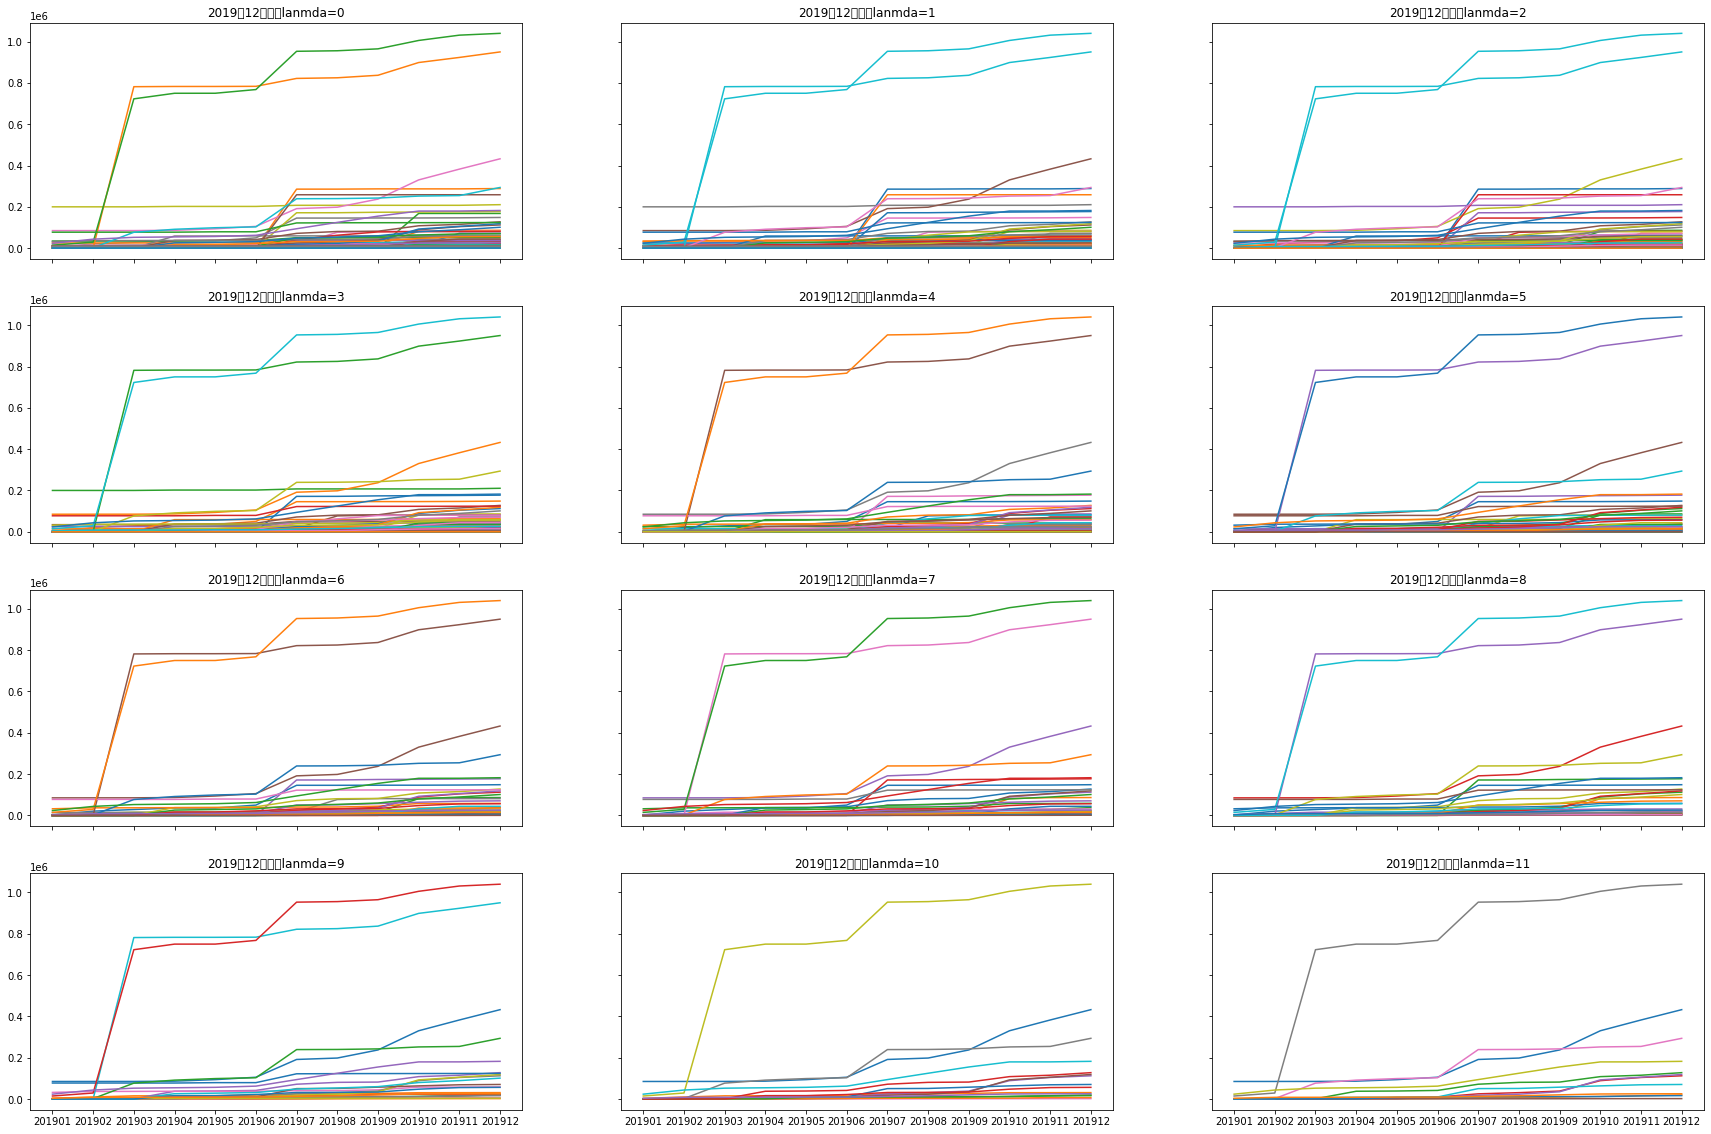

In [93]:
#超参lamda=2  代表统计周期中，发生过度变化的月数
lamda=[[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
# 2行 2列布局的子图
fig4v3 , ax4v3=plt.subplots(4,3,
	sharex=True,
	sharey=True)  #x、y 轴共享属性：刻度标签
fig4v3.set_size_inches(30,20) #画布尺寸
for i in range(0,4):
    for j in range(0,3):
        temp=df_repo_date_weight[df_repo_date_weight['months_not_zero']>lamda[i][j]]
        temp = temp.reset_index(drop=True)
        ax4v3[i,j].set_title(f"2019年12个月，lanmda={lamda[i][j]}")
        for k in range(0,temp.shape[0]):
            row=temp.loc[k]
            #筛选出12个月的列
            ax4v3[i,j].plot(row[3:15])

### 步骤1 预测

#### 2.1 模型

In [135]:
def linear_predict(x, a, b):
    return a * x + b

def Bass_predict(x, m, p, q):
    return m * (p * (p + q) ** 2) * e ** (x) / ((p + q * e ** (x)) ** 2)
    # return (p+(q/m)*(x))*(m-x)

def Gompertz_predict(x, k, a):
    return k * np.e ** a ** x

def BA_predict(x, b):
    return b * (x ** 0.5)

def BB_predict(x, a, b):
    return b * (x ** a)

# Mean Squared Error
def MSE(n, expects, reals):
    mse = 0
    for i in range(0, n):
        mse += math.pow(expects[i] - reals[i], 2)
    mse /= n
    return np.round(mse, 2)

# Root Mean Squared Error
def RMSE(n, expects, reals):
    rmse = 0
    for i in range(0, n):
        rmse += math.pow(expects[i] - reals[i], 2)
    rmse /= n
    rmse = math.pow(rmse, 0.5)
    return np.round(rmse, 2)

# Mean absolute Error
def MAE(n, expects, reals):
    mae = 0
    for i in range(0, n):
        mae += abs(expects[i] - reals[i])
    mae /= n
    return np.round(mae, 2)

# Root Mean Squared Logaritmic Error
def RMSLE(n, expects, reals):
    rmsle = 0
    for i in range(0, n):
        rmsle += math.pow(math.log(expects[i]+1) - math.log(reals[i]+1), 2)
    rmsle /= n
    rmsle = math.pow(rmsle, 0.5)
    return round(rmsle, 2)

### 2.2 预测

In [136]:
date_list = ["201901", "201902", "201903", "201904", "201905", "201906", "201907", "201908", "201909", "201910", "201911", "201912"]

def linear_prediction(selected_repo):
    repo_predict_res = {}
    reals = []
    expects = []
    num_of_repo = 1
    x_data = [1,2,3,4,5,6,7,8,9,10,11]
    y_data = []
    for date in date_list:
        if(date != "201912"):
            y_data.append(selected_repo[date])
    popt_1, pcov_1 = curve_fit(linear_predict, x_data, y_data)
    linear_params = popt_1
    reals.append(selected_repo["201912"])
    x_data.append(12)
    y_data_1 = [linear_predict(i, popt_1[0], popt_1[1]) for i in x_data]
    expects.append(round(y_data_1[11], 2)) 
    repo_predict_res["repo_name"] = selected_repo["repo_name"]
    repo_predict_res["t_start"] = "2019-01"
    repo_predict_res["t_end"] = "2019-12"
    repo_predict_res["real"] = selected_repo["201912"]
    repo_predict_res["linear_predict"] = round(y_data_1[11], 2)
    repo_predict_res['linear_params'] = [popt_1[0] ,popt_1[1]]
    # print("Mean Squared Error Of linear_predict: " + str(MSE(num_of_repo, expects, reals)))
    # print("Root Mean Squared Error Of linear_predict: " + str(RMSE(num_of_repo, expects, reals)))
    # print("Mean absolute Error Of linear_predict: " + str(MAE(num_of_repo, expects, reals)))
    # print()
    return repo_predict_res

def BB_prediction(selected_repo):
    repo_predict_res = {}
    reals = []
    expects = []
    num_of_repo = 1
    x_data = [1,2,3,4,5,6,7,8,9,10,11]
    y_data = []
    for date in date_list:
        if(date != "201912"):
            y_data.append(selected_repo[date])
    popt_1, pcov_1 = curve_fit(BB_predict, x_data, y_data)
    linear_params = popt_1
    reals.append(selected_repo["201912"])
    x_data.append(12)
    y_data_1 = [BB_predict(i, popt_1[0], popt_1[1]) for i in x_data]
    expects.append(round(y_data_1[11], 2)) 
    repo_predict_res["repo_name"] = selected_repo["repo_name"]
    repo_predict_res["t_start"] = "2019-01"
    repo_predict_res["t_end"] = "2019-12"
    repo_predict_res["real"] = selected_repo["201912"]
    repo_predict_res["bb_predict"] = round(y_data_1[11], 2)
    repo_predict_res['bb_params'] = [popt_1[0] ,popt_1[1]]
    # print("Mean Squared Error Of linear_predict: " + str(MSE(num_of_repo, expects, reals)))
    # print("Root Mean Squared Error Of linear_predict: " + str(RMSE(num_of_repo, expects, reals)))
    # print("Mean absolute Error Of linear_predict: " + str(MAE(num_of_repo, expects, reals)))
    # print()
    return repo_predict_res   

def Ridge_prediction(selected_repo):
    repo_predict_res = {}
    reals = []
    expects = []
    num_of_repo = 1
    x_data = [1,2,3,4,5,6,7,8,9,10,11]
    y_data = []
    for date in date_list:
        if(date != "201912"):
            y_data.append(selected_repo[date])
    ridge = RidgeCV(cv=5)
    ridge.fit(np.array(x_data).reshape(-1, 1), y_data)
    x_data.append(12)
    y_data_1 = ridge.predict(np.array(x_data).reshape(-1,1))
    # # 查看最佳正则化系数
    # print("Ridge best alpha: ", lasso.alpha_)
    reals.append(selected_repo["201912"])

    expects.append(round(y_data_1[11], 2)) 
    repo_predict_res["repo_name"] = selected_repo["repo_name"]
    repo_predict_res["t_start"] = "2019-01"
    repo_predict_res["t_end"] = "2019-12"
    repo_predict_res["real"] = selected_repo["201912"]
    repo_predict_res["y_data"] = y_data_1
    repo_predict_res["ridge_model"] = ridge
    # print("Mean Squared Error Of linear_predict: " + str(MSE(num_of_repo, expects, reals)))
    # print("Root Mean Squared Error Of linear_predict: " + str(RMSE(num_of_repo, expects, reals)))
    # print("Mean absolute Error Of linear_predict: " + str(MAE(num_of_repo, expects, reals)))
    # print()
    return repo_predict_res   

def Lasso_prediction(selected_repo):
    repo_predict_res = {}
    reals = []
    expects = []
    num_of_repo = 1
    x_data = [1,2,3,4,5,6,7,8,9,10,11]
    y_data = []
    for date in date_list:
        if(date != "201912"):
            y_data.append(selected_repo[date])
    # 交叉验证正则化参数，默认5折
    lasso = LassoCV(cv=5, max_iter=100000)
    lasso.fit(np.array(x_data).reshape(-1, 1), y_data)
    x_data.append(12)
    y_data_1 = lasso.predict(np.array(x_data).reshape(-1,1))
    # print(y_data_1)
    # # 查看最佳正则化系数
    # print("Lasso best alpha: " ,lasso.alpha_)
    reals.append(selected_repo["201912"])
    
    expects.append(round(y_data_1[11], 2)) 
    repo_predict_res["repo_name"] = selected_repo["repo_name"]
    repo_predict_res["t_start"] = "2019-01"
    repo_predict_res["t_end"] = "2019-12"
    repo_predict_res["real"] = selected_repo["201912"]
    repo_predict_res["y_data"] = y_data_1
    repo_predict_res["lasso_model"] = lasso
    # print("Mean Squared Error Of linear_predict: " + str(MSE(num_of_repo, expects, reals)))
    # print("Root Mean Squared Error Of linear_predict: " + str(RMSE(num_of_repo, expects, reals)))
    # print("Mean absolute Error Of linear_predict: " + str(MAE(num_of_repo, expects, reals)))
    # print()
    return repo_predict_res   

    # def predict():
#     res_map = selected_repos
#     predict_list = []
#     reals = []
#     expect_1 = []
#     expect_2 = []
#     expect_3 = []
#     expect_4 = []
#     expect_5 = []
#     expect_6 = []
#     expect_7 = []
#     linear_params = []
#     BA_params = []
#     BB_params = []
#     Base_params = []
#     Gompertz_params = []
#     C = 1.255
#     num_of_repo = 0
#     for selected_repo in selected_repos:
#         repo_predict_res = {}
#         num_of_repo += 1
#         x_data = [1,2,3,4,5,6,7,8,9,10,11]
#         y_data = []
#         for date in date_list:
#             if(date != "201912"):
#                 y_data.append(selected_repo[date])
#         popt_1, pcov_1 = curve_fit(linear_predict, x_data, y_data)
#         popt_2, pcov_2 = curve_fit(BA_predict, x_data, y_data)
#         popt_3, pcov_3 = curve_fit(BB_predict, x_data, y_data, maxfev=100000)
#         popt_4, pcov_4 = curve_fit(Bass_predict, x_data, y_data, maxfev=500000)
#         popt_5, pcov_5 = curve_fit(Gompertz_predict, x_data, y_data, maxfev=500000)
#         # 0.01 - 100 中选择 alpha
#         alpha_range = np.logspace(-6, 6, 200, base=10)
#         # 交叉验证正则化参数，默认5折
#         lasso = LassoCV(cv=5, max_iter=100000)
#         lasso.fit(np.array(x_data).reshape(-1, 1), y_data)
#         # # 查看最佳正则化系数
#         # print("Lasso best alpha: " ,lasso.alpha_)
#         ridge = RidgeCV(cv=5)
#         ridge.fit(np.array(x_data).reshape(-1, 1), y_data)
#         # # 查看最佳正则化系数
#         # print("Ridge best alpha: ", lasso.alpha_)

#         linear_params.append(popt_1)
#         BA_params.append(popt_2)
#         BB_params.append(popt_3)
#         # Base_params.append(popt_4)
#         # Gompertz_params.append(popt_5)
#         reals.append(selected_repo["201912"])

#         x_data.append(12)
#         y_data_1 = [linear_predict(i, popt_1[0], popt_1[1]) for i in x_data]
#         y_data_2 = [BA_predict(i, popt_2[0]) for i in x_data]
#         y_data_3 = [BB_predict(i, popt_3[0], popt_3[1]) for i in x_data]
#         y_data_4 = [Bass_predict(i, popt_4[0], popt_4[1], popt_4[2]) for i in x_data]
#         y_data_5 = [Gompertz_predict(i, popt_5[0], popt_5[1]) for i in x_data]
#         y_data_6 = lasso.predict(np.array(x_data).reshape(-1,1))
#         y_data_7 = ridge.predict(np.array(x_data).reshape(-1,1))

#         expect_1.append(round(y_data_1[11], 2))
#         expect_2.append(round(y_data_2[11], 2))
#         expect_3.append(round(y_data_3[11], 2))
#         expect_4.append(round(y_data_4[11], 2))
#         expect_5.append(round(y_data_5[11], 2))
#         expect_6.append(round(y_data_6[11], 2))
#         expect_7.append(np.round(y_data_7[11], 2))

#         fitness = popt_3[0] * C

#         repo_predict_res["repo_name"] = selected_repo["repo_name"]
#         repo_predict_res["t_start"] = "2019-01"
#         repo_predict_res["t_end"] = "2019-12"
#         repo_predict_res["real"] = selected_repo["201912"]
#         repo_predict_res["linear_predict"] = round(y_data_1[11], 2)
#         repo_predict_res["BA_predict"] = round(y_data_2[11], 2)
#         repo_predict_res["BB_predict"] = round(y_data_3[11], 2)
#         repo_predict_res["Bass_predict"] = round(y_data_4[11], 2)
#         repo_predict_res["Gompertz_predict"] = round(y_data_5[11], 2)
#         repo_predict_res["lasso_predict"] = round(y_data_6[11], 2)
#         repo_predict_res["ridge_predict"] = np.round(y_data_7[11], 2)
#         repo_predict_res["fitness"] = round(fitness, 2)
#         predict_list.append(repo_predict_res)

#     for p in predict_list:
#         print(p)

#     print("Mean Squared Error Of linear_predict: " + str(MSE(num_of_repo, expect_1, reals)))
#     print("Root Mean Squared Error Of linear_predict: " + str(RMSE(num_of_repo, expect_1, reals)))
#     print("Mean absolute Error Of linear_predict: " + str(MAE(num_of_repo, expect_1, reals)))
#     print()
#     print("Mean Squared Error Of BA_predict: " + str(MSE(num_of_repo, expect_2, reals)))
#     print("Root Mean Squared Error Of BA_predict: " + str(RMSE(num_of_repo, expect_2, reals)))
#     print("Mean absolute Error Of BA_predict: " + str(MAE(num_of_repo, expect_2, reals)))
#     print()
#     print("Mean Squared Error Of BB_predict: " + str(MSE(num_of_repo, expect_3, reals)))
#     print("Root Mean Squared Error Of BB_predict: " + str(RMSE(num_of_repo, expect_3, reals)))
#     print("Mean absolute Error Of BB_predict: " + str(MAE(num_of_repo, expect_3, reals)))
#     print()
#     print("Mean Squared Error Of Bass_predict: " + str(MSE(num_of_repo, expect_4, reals)))
#     print("Root Mean Squared Error Of Bass_predict: " + str(RMSE(num_of_repo, expect_4, reals)))
#     print("Mean absolute Error Of Bass_predict: " + str(MAE(num_of_repo, expect_4, reals)))
#     print()
#     print("Mean Squared Error Of Gompertz_predict: " + str(MSE(num_of_repo, expect_5, reals)))
#     print("Root Mean Squared Error Of Gompertz_predict: " + str(RMSE(num_of_repo, expect_5, reals)))
#     print("Mean absolute Error Of Gompertz_predict: " + str(MAE(num_of_repo, expect_5, reals)))
#     print()
#     print("Mean Squared Error Of lasso_predict: " + str(MSE(num_of_repo, expect_6, reals)))
#     print("Root Mean Squared Error Of lasso_predict: " + str(RMSE(num_of_repo, expect_6, reals)))
#     print("Mean absolute Error Of lasso_predict: " + str(MAE(num_of_repo, expect_6, reals)))
#     print()
#     print("Mean Squared Error Of ridge_predict: " + str(MSE(num_of_repo, expect_7, reals)))
#     print("Root Mean Squared Error Of ridge_predict: " + str(RMSE(num_of_repo, expect_7, reals)))
#     print("Mean absolute Error Of ridge_predict: " + str(MAE(num_of_repo, expect_7, reals)))
#     res = {}
#     res["predict_list"] = predict_list
#     res["linear_params"] = linear_params
#     res["BA_params"] = BA_params
#     res["BB_params"] = BB_params
#     return res

#### 2.3 BB预测绘图

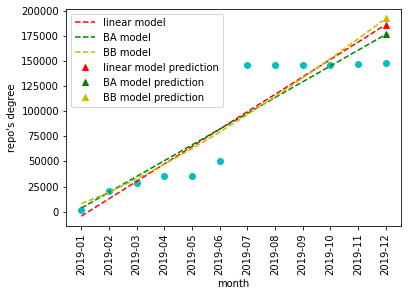

TypeError: [186454.47] is not a callable object

In [137]:
for selected_repo in selected_repos:
    predict_map_linear = linear_prediction(selected_repo)
    predict_map_bb = BB_prediction(selected_repo)
    predict_map_lasso = Lasso_prediction(selected_repo)
    x = [1,2,3,4,5,6,7,8,9,10,11,12]
    x_range = np.arange(1, 12, 0.1)
    y_linear = linear_predict(x_range, predict_map_linear['linear_params'][0], predict_map_linear['linear_params'][1])
    y_BB = BB_predict(x_range, predict_map_bb['bb_params'][0], predict_map_bb['bb_params'][1])
    y_lasso = predict_map_lasso['y_data']
    lasso_model = predict_map_lasso['lasso_model']
    
    x_points = ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12']
    y_points = [selected_repo['201901'],selected_repo['201902'],selected_repo['201903'],
                selected_repo['201904'],selected_repo['201905'],selected_repo['201906'],
                selected_repo['201907'],selected_repo['201908'],selected_repo['201909'],
                selected_repo['201910'],selected_repo['201911'], selected_repo['201912']
                ]
    x_expect = [12]
    linear_predict = [predict_map_linear['linear_predict']]
    BB_predict = [predict_map_bb['bb_predict']]
    plt.plot(x, y_points, 'co')
    line1, = plt.plot(x_range, y_linear,'r--')
    point1, = plt.plot(x_expect, linear_predict, 'r^')
    line2, = plt.plot(x_range, lasso_model.predict(np.array(x_range).reshape(-1,1)),'g--')
    point2, = plt.plot(x_expect, lasso_model.predict(np.array(x_expect).reshape(-1,1)), 'g^')
    line3, = plt.plot(x_range, y_BB,'y--')
    point3, = plt.plot(x_expect, BB_predict, 'y^')
    plt.title("")
    plt.xlabel("month")
    plt.ylabel("repo's degree")
    plt.legend([line1, line2, line3, point1, point2, point3],
            ["linear model", "lasso model", "BB model", "linear model prediction", "lasso model prediction", "BB model prediction"],
            loc="upper left")
    plt.xticks(x, x_points, rotation='vertical')
    plt.show()